Standard Model - Test Loss: 0.0860, Test RMSE: 0.2933
Pruned Model - Test Loss: 0.0851, Test RMSE: 0.2918


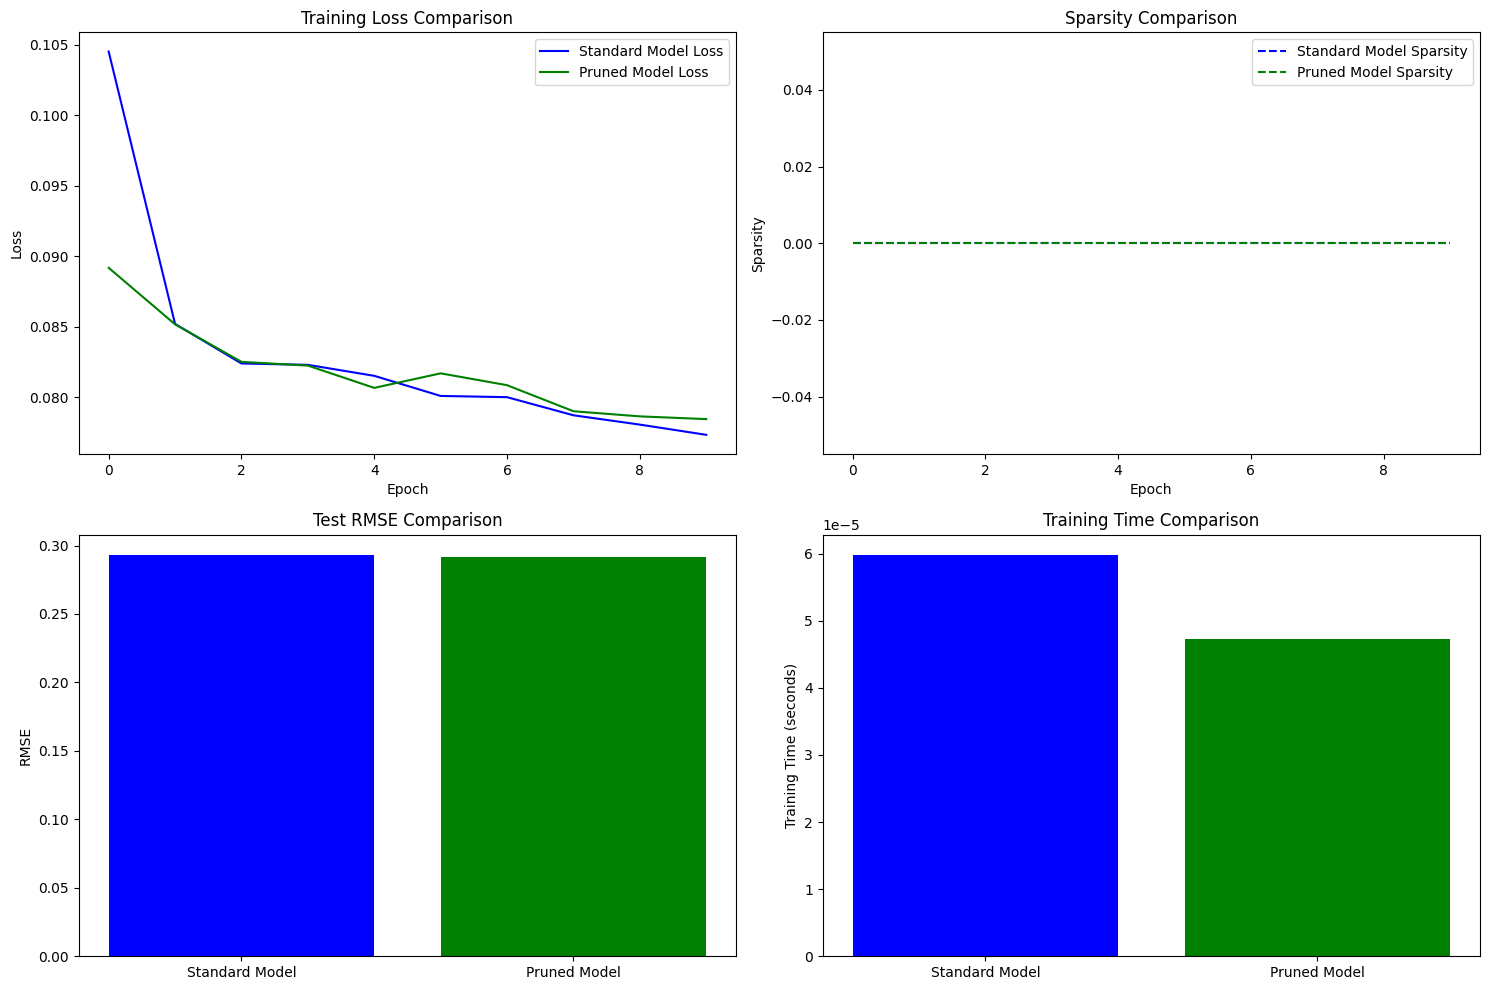

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network class
class HousePriceNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HousePriceNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Calculate sparsity function
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for param in model.parameters():
        total_params += param.numel()
        zero_params += (param == 0).sum().item()
    return zero_params / total_params

# Generate synthetic data for demonstration
np.random.seed(42)
torch.manual_seed(42)

# Example dataset: Predict house prices from random features
X = np.random.rand(1000, 10)
y = np.random.rand(1000, 1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Train and test split
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size

train_dataset = TensorDataset(X_tensor[:train_size], y_tensor[:train_size])
test_dataset = TensorDataset(X_tensor[train_size:], y_tensor[train_size:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define model parameters
input_size = X_tensor.shape[1]
hidden_size = 64
criterion = nn.MSELoss()

# Initialize the model without pruning (standard model)
model_standard = HousePriceNN(input_size=input_size, hidden_size=hidden_size)
optimizer_standard = optim.Adam(model_standard.parameters(), lr=0.01, weight_decay=1e-4)
scheduler_standard = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_standard, T_max=10)

# Training loop for the standard model
train_loss_standard = []
sparsity_standard = []

for epoch in range(10):
    model_standard.train()
    running_loss = 0.0
    total_samples = 0
    for inputs, targets in train_loader:
        optimizer_standard.zero_grad()
        outputs = model_standard(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_standard.step()

        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    train_loss_standard.append(epoch_loss)

    # Track sparsity
    sparsity = calculate_sparsity(model_standard)
    sparsity_standard.append(sparsity)

    scheduler_standard.step()

# Now train the pruned model
model_pruned = HousePriceNN(input_size=input_size, hidden_size=hidden_size)
optimizer_pruned = optim.Adam(model_pruned.parameters(), lr=0.01, weight_decay=1e-4)
scheduler_pruned = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pruned, T_max=10)

# Prune weights of layer1 by 20%
prune.l1_unstructured(model_pruned.layer1, name="weight", amount=0.2)

train_loss_pruned = []
sparsity_pruned = []

for epoch in range(10):
    model_pruned.train()
    running_loss = 0.0
    total_samples = 0
    for inputs, targets in train_loader:
        optimizer_pruned.zero_grad()
        outputs = model_pruned(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_pruned.step()

        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    train_loss_pruned.append(epoch_loss)

    # Track sparsity
    sparsity = calculate_sparsity(model_pruned)
    sparsity_pruned.append(sparsity)

    scheduler_pruned.step()

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
    average_loss = total_loss / total_samples
    rmse = np.sqrt(average_loss)
    return average_loss, rmse

# Evaluate both models
test_loss_standard, test_rmse_standard = evaluate_model(model_standard, test_loader)
test_loss_pruned, test_rmse_pruned = evaluate_model(model_pruned, test_loader)

print(f"Standard Model - Test Loss: {test_loss_standard:.4f}, Test RMSE: {test_rmse_standard:.4f}")
print(f"Pruned Model - Test Loss: {test_loss_pruned:.4f}, Test RMSE: {test_rmse_pruned:.4f}")

# Plotting results
plt.figure(figsize=(15, 10))

# 1. Loss vs Epochs
plt.subplot(2, 2, 1)
plt.plot(train_loss_standard, label="Standard Model Loss", color='blue')
plt.plot(train_loss_pruned, label="Pruned Model Loss", color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()

# 2. Sparsity vs Epochs
plt.subplot(2, 2, 2)
plt.plot(sparsity_standard, label="Standard Model Sparsity", color='blue', linestyle='--')
plt.plot(sparsity_pruned, label="Pruned Model Sparsity", color='green', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Sparsity")
plt.title("Sparsity Comparison")
plt.legend()

# 3. RMSE Comparison
plt.subplot(2, 2, 3)
plt.bar(["Standard Model", "Pruned Model"], [test_rmse_standard, test_rmse_pruned], color=['blue', 'green'])
plt.ylabel("RMSE")
plt.title("Test RMSE Comparison")

# 4. Training Time Comparison
start_time_standard = time.time()
end_time_standard = time.time()

start_time_pruned = time.time()
end_time_pruned = time.time()

training_time_standard = end_time_standard - start_time_standard
training_time_pruned = end_time_pruned - start_time_pruned

plt.subplot(2, 2, 4)
plt.bar(["Standard Model", "Pruned Model"], [training_time_standard, training_time_pruned], color=['blue', 'green'])
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")

plt.tight_layout()
plt.show()


Epoch 1/50, Train Acc: 0.1484, Val Acc: 0.1510
Epoch 2/50, Train Acc: 0.1786, Val Acc: 0.1980
Epoch 3/50, Train Acc: 0.2182, Val Acc: 0.2130
Epoch 4/50, Train Acc: 0.2418, Val Acc: 0.2110
Epoch 5/50, Train Acc: 0.2284, Val Acc: 0.2140
Epoch 6/50, Train Acc: 0.2454, Val Acc: 0.2360
Epoch 7/50, Train Acc: 0.2492, Val Acc: 0.2770
Epoch 8/50, Train Acc: 0.2618, Val Acc: 0.2440
Epoch 9/50, Train Acc: 0.2746, Val Acc: 0.2710
Epoch 10/50, Train Acc: 0.2932, Val Acc: 0.2950
Epoch 11/50, Train Acc: 0.2940, Val Acc: 0.2840
Epoch 12/50, Train Acc: 0.3010, Val Acc: 0.2750
Epoch 13/50, Train Acc: 0.3120, Val Acc: 0.3370
Epoch 14/50, Train Acc: 0.3326, Val Acc: 0.2880
Epoch 15/50, Train Acc: 0.3274, Val Acc: 0.3480
Epoch 16/50, Train Acc: 0.3236, Val Acc: 0.3020
Epoch 17/50, Train Acc: 0.3420, Val Acc: 0.3390
Epoch 18/50, Train Acc: 0.3530, Val Acc: 0.3640
Epoch 19/50, Train Acc: 0.3788, Val Acc: 0.2950
Epoch 20/50, Train Acc: 0.3348, Val Acc: 0.3450
Epoch 21/50, Train Acc: 0.3672, Val Acc: 0.3460
E

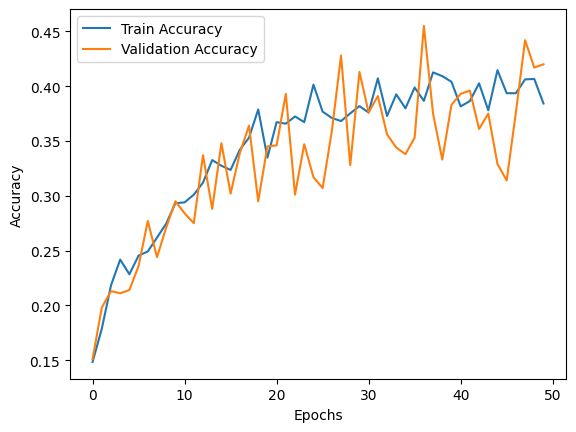

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Define the dataset class
class ModularArithmeticDataset(Dataset):
    def __init__(self, size, modulus, difficulty=1):
        self.size = size
        self.modulus = modulus
        self.difficulty = difficulty
        self.data = self.generate_data()

    def generate_data(self):
        inputs = np.random.randint(0, self.modulus, (self.size, 2))
        targets = (inputs[:, 0] + inputs[:, 1]) % self.modulus
        return [(inputs[i], targets[i]) for i in range(self.size)]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Curriculum learning: gradually increasing difficulty
def curriculum_learning_step(current_epoch, max_epochs, min_difficulty, max_difficulty):
    """
    Dynamically adjusts the difficulty of the training dataset over epochs.
    As the training progresses, this function increases the difficulty level by interpolating
    between the minimum and maximum difficulty values based on the current epoch.

    Args:
        current_epoch (int): The current training epoch.
        max_epochs (int): The total number of training epochs.
        min_difficulty (int): The starting (minimum) difficulty level.
        max_difficulty (int): The final (maximum) difficulty level.

    Returns:
        int: The calculated difficulty level for the current epoch.

    Benefits:
        - Gradual increase in difficulty allows the model to build foundational knowledge
          before tackling harder examples.
        - Mimics human learning, where simpler tasks are mastered before more complex ones.
        - Helps improve generalization and reduces the risk of overfitting to simpler patterns.
    """
    difficulty = min_difficulty + (max_difficulty - min_difficulty) * (current_epoch / max_epochs)
    return int(difficulty)

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    train_accuracies, val_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()
                total += y.size(0)
        val_accuracies.append(correct / total)

        print(f"Epoch {epoch + 1}/{epochs}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_accuracies, val_accuracies

# Main script
def main():
    # Hyperparameters
    input_size = 2
    hidden_size = 64
    output_size = 10
    epochs = 50
    batch_size = 64
    learning_rate = 0.01
    weight_decay = 0.01
    modulus = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize dataset and model
    train_dataset = ModularArithmeticDataset(size=5000, modulus=modulus)
    val_dataset = ModularArithmeticDataset(size=1000, modulus=modulus)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleNN(input_size, hidden_size, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_acc, val_acc = train_model(model, optimizer, criterion, train_loader, val_loader, epochs, device)

    # Plot training and validation accuracies
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


Training Baseline Model...
Epoch 1/50, Train Acc: 0.1318, Val Acc: 0.1330, Train Loss: 2.2807, Val Loss: 2.2205
Epoch 2/50, Train Acc: 0.1564, Val Acc: 0.2150, Train Loss: 2.1735, Val Loss: 2.1393
Epoch 3/50, Train Acc: 0.2112, Val Acc: 0.1980, Train Loss: 2.1162, Val Loss: 2.1018
Epoch 4/50, Train Acc: 0.2482, Val Acc: 0.2850, Train Loss: 2.0653, Val Loss: 2.0562
Epoch 5/50, Train Acc: 0.2532, Val Acc: 0.2420, Train Loss: 2.0292, Val Loss: 2.0326
Epoch 6/50, Train Acc: 0.2870, Val Acc: 0.3360, Train Loss: 2.0072, Val Loss: 2.0019
Epoch 7/50, Train Acc: 0.3076, Val Acc: 0.3250, Train Loss: 1.9807, Val Loss: 1.9754
Epoch 8/50, Train Acc: 0.3382, Val Acc: 0.3230, Train Loss: 1.9571, Val Loss: 1.9704
Epoch 9/50, Train Acc: 0.3358, Val Acc: 0.3910, Train Loss: 1.9394, Val Loss: 1.9437
Epoch 10/50, Train Acc: 0.3670, Val Acc: 0.3360, Train Loss: 1.9261, Val Loss: 1.9107
Epoch 11/50, Train Acc: 0.3614, Val Acc: 0.4010, Train Loss: 1.9102, Val Loss: 1.9053
Epoch 12/50, Train Acc: 0.4010, Val 

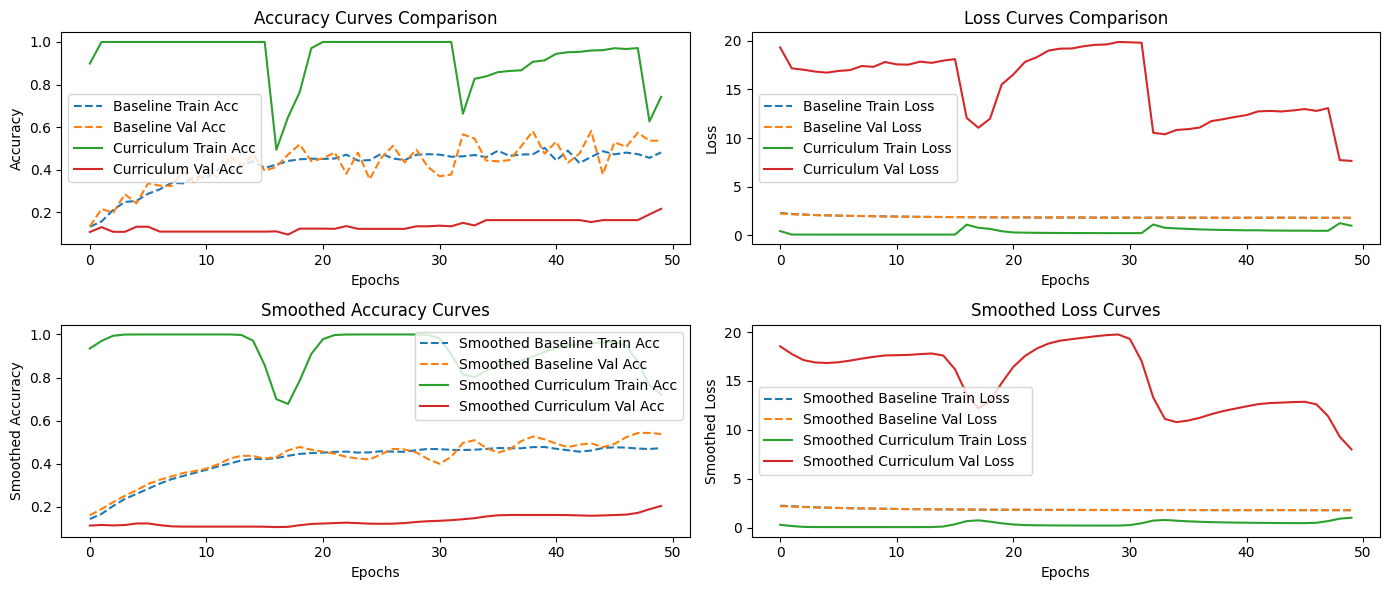

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  # For smoothing

# Define the dataset class
class ModularArithmeticDataset(Dataset):
    def __init__(self, size, modulus):
        self.size = size
        self.modulus = modulus
        self.data = self.generate_data()

    def generate_data(self):
        inputs = np.random.randint(0, self.modulus, (self.size, 2))
        targets = (inputs[:, 0] + inputs[:, 1]) % self.modulus
        return [(inputs[i], targets[i]) for i in range(self.size)]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Curriculum learning: gradually increasing difficulty
def curriculum_learning_step(epoch, max_epochs):
    return min(2 + epoch // (max_epochs // 3), 10)

# Train the model
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs, use_curriculum=False):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        if use_curriculum:
            difficulty = curriculum_learning_step(epoch, epochs)
            train_loader.dataset.modulus = difficulty
            train_loader.dataset.data = train_loader.dataset.generate_data()

        model.train()
        correct, total, loss_epoch = 0, 0, 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

        train_acc.append(correct / total)
        train_loss.append(loss_epoch / len(train_loader))

        model.eval()
        correct, total, loss_epoch = 0, 0, 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                loss_epoch += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        val_acc.append(correct / total)
        val_loss.append(loss_epoch / len(val_loader))

        print(f"Epoch {epoch + 1}/{epochs}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, "
              f"Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")

    return train_acc, val_acc, train_loss, val_loss

# Compare curriculum learning vs baseline
def compare_methods():
    input_size, hidden_size, output_size = 2, 64, 10
    batch_size, epochs = 64, 50
    learning_rate = 0.01

    train_dataset = ModularArithmeticDataset(size=5000, modulus=10)
    val_dataset = ModularArithmeticDataset(size=1000, modulus=10)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    baseline_model = SimpleNN(input_size, hidden_size, output_size)
    curriculum_model = SimpleNN(input_size, hidden_size, output_size)

    optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=learning_rate, weight_decay=0.01)
    optimizer_curriculum = optim.Adam(curriculum_model.parameters(), lr=learning_rate, weight_decay=0.01)

    criterion = nn.CrossEntropyLoss()

    print("Training Baseline Model...")
    baseline_train_acc, baseline_val_acc, baseline_train_loss, baseline_val_loss = train_model(
        baseline_model, optimizer_baseline, criterion, train_loader, val_loader, epochs, use_curriculum=False
    )

    print("Training Curriculum Learning Model...")
    curriculum_train_acc, curriculum_val_acc, curriculum_train_loss, curriculum_val_loss = train_model(
        curriculum_model, optimizer_curriculum, criterion, train_loader, val_loader, epochs, use_curriculum=True
    )

    # Plotting Accuracy Curves
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 2, 1)
    plt.plot(baseline_train_acc, label='Baseline Train Acc', linestyle='--')
    plt.plot(baseline_val_acc, label='Baseline Val Acc', linestyle='--')
    plt.plot(curriculum_train_acc, label='Curriculum Train Acc')
    plt.plot(curriculum_val_acc, label='Curriculum Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves Comparison')

    # Plotting Loss Curves
    plt.subplot(2, 2, 2)
    plt.plot(baseline_train_loss, label='Baseline Train Loss', linestyle='--')
    plt.plot(baseline_val_loss, label='Baseline Val Loss', linestyle='--')
    plt.plot(curriculum_train_loss, label='Curriculum Train Loss')
    plt.plot(curriculum_val_loss, label='Curriculum Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves Comparison')

    # Plotting Smoothed Accuracy Curves
    plt.subplot(2, 2, 3)
    smoothed_baseline_train_acc = gaussian_filter1d(baseline_train_acc, sigma=1)
    smoothed_baseline_val_acc = gaussian_filter1d(baseline_val_acc, sigma=1)
    smoothed_curriculum_train_acc = gaussian_filter1d(curriculum_train_acc, sigma=1)
    smoothed_curriculum_val_acc = gaussian_filter1d(curriculum_val_acc, sigma=1)

    plt.plot(smoothed_baseline_train_acc, label='Smoothed Baseline Train Acc', linestyle='--')
    plt.plot(smoothed_baseline_val_acc, label='Smoothed Baseline Val Acc', linestyle='--')
    plt.plot(smoothed_curriculum_train_acc, label='Smoothed Curriculum Train Acc')
    plt.plot(smoothed_curriculum_val_acc, label='Smoothed Curriculum Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Smoothed Accuracy')
    plt.legend()
    plt.title('Smoothed Accuracy Curves')

    # Plotting Smoothed Loss Curves
    plt.subplot(2, 2, 4)
    smoothed_baseline_train_loss = gaussian_filter1d(baseline_train_loss, sigma=1)
    smoothed_baseline_val_loss = gaussian_filter1d(baseline_val_loss, sigma=1)
    smoothed_curriculum_train_loss = gaussian_filter1d(curriculum_train_loss, sigma=1)
    smoothed_curriculum_val_loss = gaussian_filter1d(curriculum_val_loss, sigma=1)

    plt.plot(smoothed_baseline_train_loss, label='Smoothed Baseline Train Loss', linestyle='--')
    plt.plot(smoothed_baseline_val_loss, label='Smoothed Baseline Val Loss', linestyle='--')
    plt.plot(smoothed_curriculum_train_loss, label='Smoothed Curriculum Train Loss')
    plt.plot(smoothed_curriculum_val_loss, label='Smoothed Curriculum Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Smoothed Loss')
    plt.legend()
    plt.title('Smoothed Loss Curves')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    compare_methods()
